# The Unreasonable Effectiveness of RNNs
The [liftothers.org lab](http://liftothers.org/dokuwiki/doku.php?id=cs501r_f2018:lab6)  
Andrej Karpathy's [blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

Are we passing in one character at a time or one sentence at a time?

In [37]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import random
import re
import string
import sys
import time
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import unidecode

torch.set_printoptions(precision=2)

## Scaffolding Code

In [68]:
all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('basketball.txt').read())
file_len = len(file)
# print('file_len =', file_len)

chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

# print(random_chunk())

# Turn string into list of longs, shape (1,n)
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

# print(char_tensor('abcDEF'))

def random_training_set():
    """
    Returns a (200,n_characters) tensor.
    """
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [69]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.i2r = nn.Linear(input_size, hidden_size)
        self.h2r = nn.Linear(hidden_size, hidden_size)
        self.i2z = nn.Linear(input_size, hidden_size)
        self.h2z = nn.Linear(hidden_size, hidden_size)
        self.i2n = nn.Linear(input_size, hidden_size)
        self.h2n = nn.Linear(hidden_size, hidden_size)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self, input, hidden):
        reset = self.sigmoid(self.i2r(input) + self.h2r(hidden))
        update = self.sigmoid(self.i2z(input) + self.h2z(hidden))
        new = self.tanh(self.i2n(input) + reset*self.h2n(hidden))
        hidden = (1-update)*new + update*hidden
        return hidden, hidden
        

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size) # maps an ASCII char to a vector
        self.gru = GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
        
    def forward(self, input, hidden):
        """
        The encoder reads an input sequence and outputs a single vector,
        the decoder reads the vector and produces an output sequence.
        Parameters:
            input (input_size)
            hidden (seq_len, batch, hidden_size)
        Returns:
            output (batch, output_size)
        """
        
        batch_size = 1
        encoded = self.encoder(input.view(1,-1))
        output, hidden = self.gru(encoded.view(1, batch_size, -1), hidden)
        output = self.relu(self.decoder(output.view(batch_size, -1)))
        return output, hidden
            
    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

In [70]:
hidden_size = 100
n_layers = 1
lr = 0.005

all_losses = []
rnn = RNN(input_size=n_characters, hidden_size=hidden_size, output_size=n_characters, n_layers=n_layers)
optimizer = optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def train(inp, target):
    """
    Parameters:
        inp (200,n_vocab)
        target (200,n_vocab)
    """
    hidden = rnn.init_hidden()
    optimizer.zero_grad()
    
    loss = 0
    for c in range(chunk_len):
        output, hidden = rnn(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))
        
    loss.backward()
    optimizer.step()
    
    return loss.item() / chunk_len

def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = rnn.init_hidden()
 
    prime_input = char_tensor(prime_str)
 
    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[p], hidden)
    inp = prime_input[-1]
 
    predicted = prime_str
    for p in range(predict_len):
        output, hidden = rnn(inp, hidden) #run your RNN/decoder forward on the input
 
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
 
        ## get character from your list of all characters, add it to your output str sequence, set input
        ## for the next pass through the model
        char = all_characters[top_i]
        predicted += char
        inp = char_tensor(char)
 
    return predicted

evaluate('Artemis')

'ArtemisJ\x0cDJ}~x \n_OKE3h_HL_gq+3{ju5]TW.[7\\cZ;8|U5D\n1BM#37]e\x0c<JQ\x0cTGVh"1^2oO}VKVDezg1P@Ckwo(x6E}ba}r;@7{<SUm7K'

In [92]:
n_epochs = 0
print_every = 20
plot_every = 20

start = time.time()
loss_avg = 0

optimizer = optim.Adam(rnn.parameters(), lr=lr)


with tqdm(total=n_epochs, position=0) as loop:
    for epoch in range(1, n_epochs+1):
        inp, target = random_training_set()
        loss_ = train(inp, target)
        loss_avg += loss_
        loop.update(1)
        if epoch % print_every == 0:
            loop.set_description("[epoch {}, loss {:.3f}]".format(epoch, loss_))
            print(evaluate('Ba', 100))

        if epoch % plot_every == 0:
            all_losses.append(loss_avg/plot_every)
            loss_avg = 0
        
print("FINAL EVAL:", evaluate('Ba'))

0it [00:00, ?it/s]

FINAL EVAL: Basketball with the with's backboard. in wor the throcust was inceter the rebounding the ball pout act


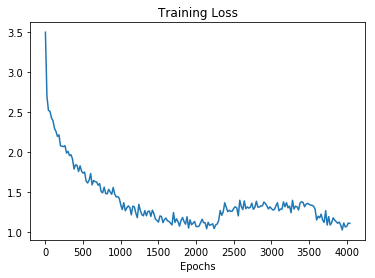

In [87]:
t = np.arange(0, plot_every*len(all_losses), plot_every)
plt.plot(t, all_losses)
plt.xlabel("Epochs")
plt.title("Training Loss")
plt.show()

In [67]:
alma_examples = [evaluate('And', predict_len=64).replace('\n','') for _ in range(15)]
for sentence in alma_examples:
    print(sentence)

And it came to the deach it resues, and also time they do noth. And Christ of the red, that name, bot
And his and the faith for him in. And noGd, be death the lands of Christ of the raind#on of the churd
And been the face the _holle dead of the land destroyed and came to buch it hard, and me had shall but 
And the city, and in they my stiXfor away, and there UZe comencemon, and all they or ]e the rei{n	r of 
And his desire for the commenled that they . And it came for had been Ammon or all the boristifore ri
And they haBe en0enly of Moroni not started of the came to be sue be dead. And the mebery, and the re
And all the votion. And graints of they muld battell be i|ner of the lait of Whould $ubtion of the Xa
And come over. And it cammant of the _^fseadinO unto need they rein$s, and the |ould `ouls of the lan
And there [reth hathall by the }9TDernined the brore or them, the camosted the red all the land, beinBe
And of they manner of the dery of his farininCished it of With by that even 

In [89]:
basketball_examples = [evaluate('Ba', predict_len=80).replace('\n','') for _ in range(15)]
for sentence in basketball_examples:
    print(sentence)

Basketball Association low-peizessfully, mezzanion pass as a shot is gain are canu
Bak Affencese basketball =ary")Anted, which player to the ball to be in oftempic
Basketball without whe bounces the lon a plays to champions that in of basket. A p
Basketball Make a ball resuler bounces the basket. X ~vental in the backboard the 
Basketball with rowd-tmat is a very to intercept forward netriest that is behandiv
Basketball from the players players. Cand, and is shaper of the preses anthandal, 
Basketballd forward to beward, the toward from are cether the most betand in becac
Basketball plays ure team with the basket. A proved, or successfully involving the
Basketball b9s shother stealail any provely in the players and whimed shot the bas
Basketball passed to skipped pass. 6 continented, as with bals is to the power for
Basketball wath becaceed plays in the primary from the oppoing the basket with bac
Basketball was rebound, and levelt a step with the a volvor man a ecase the passit
Basket